# ResNet-18 CNN: PyTorch, albumentations, CIFAR-10

Using Gaussian Error Linear Unit (GeLU) activation function instead of ReLU.

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import cv2
import os, pickle
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np

C:\Users\arjun\anaconda3\envs\torch-cuda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"currently available device: {device}")

currently available device: cuda


In [4]:
# Get number of multiple GPUs (if any)-
print(f"number of available GPUs = {torch.cuda.device_count()}")

# Get current GPU-
print(f"Current GPU = {torch.cuda.current_device()}")

# Get name of current GPU-
print(f"Name of current GPU being used = {torch.cuda.get_device_name(torch.cuda.current_device())}")

number of available GPUs = 1
Current GPU = 0
Name of current GPU being used = NVIDIA GeForce RTX 3080 Laptop GPU


In [5]:
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 1.13.1


In [6]:
# Hyper-parameters-
num_epochs = 50
batch_size = 128
learning_rate = 0.01

In [7]:
# Define transformations using albumentations-
transform_train = A.Compose(
    [
        # A.Resize(width = 32, height = 32),
        # A.RandomCrop(width = 20, height = 20),
        A.Rotate(limit = 40, p = 0.9, border_mode = cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.1),
        A.RGBShift(r_shift_limit = 25, g_shift_limit = 25, b_shift_limit = 25, p = 0.9),
        A.OneOf([
            # A.Blur(blur_limit = 3, p = 0.5),
            A.ColorJitter(p = 0.5),
        ], p = 1.0),
        A.Normalize(
            # mean = [0.4914, 0.4822, 0.4465],
            # std = [0.247, 0.243, 0.261],
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255,
        ),
        # This is not dividing by 255, which it does in PyTorch-
        ToTensorV2(),
    ]
)

transform_val = A.Compose(
    [
        A.Normalize(
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255
        ),
        ToTensorV2()
    ]
)

In [ ]:
"""
# Define transformations for training and test sets-
transform_train = transforms.Compose(
    [
      transforms.RandomCrop(32, padding = 4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
     ]
     )

transform_test = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
     ]
     )
"""

In [ ]:
"""
# Load dataset-
train_dataset = torchvision.datasets.CIFAR10(
        root = 'C:/Users/arjun/Downloads/data/', train = True,
        download = True, transform = transform_train
        )

test_dataset = torchvision.datasets.CIFAR10(
        root = 'C:/Users/arjun/Downloads/data/', train = False,
        download = True, transform = transform_val
        )
"""

In [8]:
class Cifar10Dataset(torchvision.datasets.CIFAR10):
    def __init__(
        self, root = "~/data/cifar10",
        train = True, download = True,
        transform = None
    ):
        super().__init__(
            root = root, train = train,
            download = download, transform = transform
        )

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image = image)
            image = transformed["image"]

        return image, label
    

In [9]:
# Define train and validate sets-
train_dataset = Cifar10Dataset(
    root = 'C:/Users/arjun/Downloads/data/', train = True,
    download = True, transform = transform_train
)

test_dataset = Cifar10Dataset(
    root = 'C:/Users/arjun/Downloads/data/', train = False,
    download = True, transform = transform_val
)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
print(f"len(train_dataset) = {len(train_dataset)} & len(test_dataset) = {len(test_dataset)}")

len(train_dataset) = 50000 & len(test_dataset) = 10000


In [11]:
# Create training and testing loaders-
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size = batch_size,
        shuffle = False
        )

In [12]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 391 & len(test_loader) = 79


In [13]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(390.625, 78.125)

In [ ]:
"""
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

# Sanity check-
images, labels = next(iter(train_loader))

images.size(), labels.shape

images.min(), images.max()

# Unnormalize images-
# images = images / 2 + 0.5

# Transpose axes for visualization-
images = np.transpose(images.numpy(), (0, 2, 3, 1))

images.shape
"""

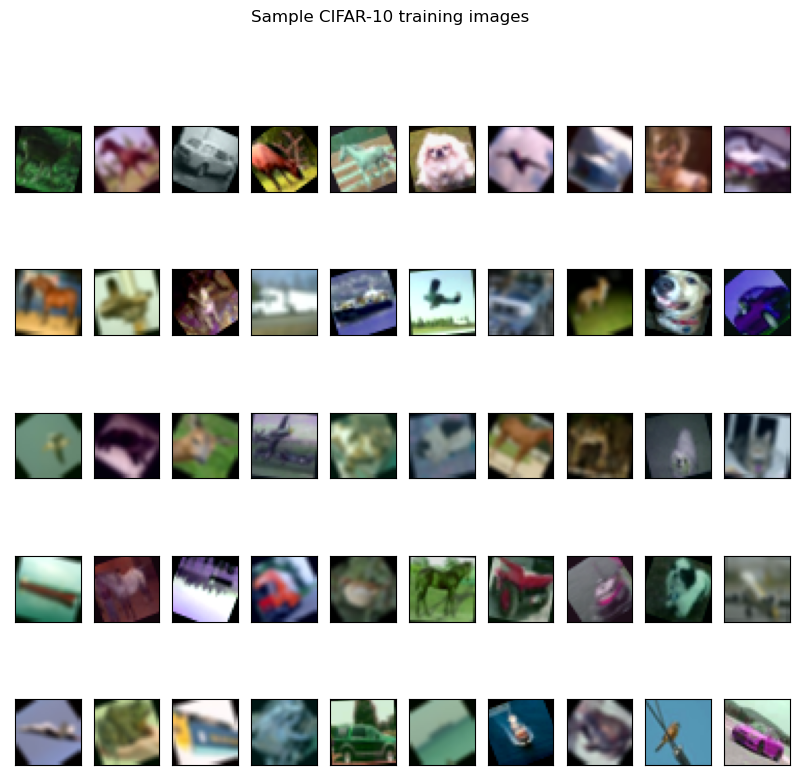

In [26]:
# Visualize 50 images from training set-
plt.figure(figsize = (10, 9))

for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(images[i])
    # get current axes-
    ax = plt.gca()

    # hide x-axis-
    ax.get_xaxis().set_visible(False)

    # hide y-axis-
    ax.get_yaxis().set_visible(False)
    
plt.suptitle("Sample CIFAR-10 training images")
plt.show()

In [ ]:
# del images, labels

### Define _ResNet-18_ architecture:

In [14]:
class ResNet_Block(nn.Module):
    '''
    VGG block within a VGG-* CNN model
    '''
    def __init__(
        self, num_inp_channels,
        num_channels, stride = 1,
        dropout = 0.2, use_1x1_conv = False
    ):
        super(ResNet_Block, self).__init__()
        
        self.num_inp_channels = num_inp_channels
        self.num_channels = num_channels
        self.stride = stride
        self.dropout = dropout
        self.use_1x1_conv = use_1x1_conv
    
        
        self.conv1 = nn.Conv2d(
            in_channels = self.num_inp_channels, out_channels = self.num_channels,
            kernel_size = 3, padding = 1,
            stride = self.stride, bias = False
        )
        self.bn1 = nn.BatchNorm2d(num_features = self.num_channels)
        
        self.conv2 = nn.Conv2d(
            in_channels = self.num_channels, out_channels = self.num_channels,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn2 = nn.BatchNorm2d(num_features = self.num_channels)
        self.dropout = nn.Dropout(p = self.dropout)
        
        if self.use_1x1_conv:
            self.conv3 = nn.Conv2d(
            in_channels = self.num_inp_channels, out_channels = num_channels,
            kernel_size = 1, padding = 0,
            stride = self.stride, bias = False
            )
            self.bn3 = nn.BatchNorm2d(num_features = self.num_channels)
        
        self.initialize_weights()

            
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)

                '''
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                '''
            
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        # Use approximate GeLU instead of exact GeLU-
        # y = F.gelu(self.bn1(self.conv1(x)), approximate = 'tanh')
        y = F.leaky_relu(self.bn1(self.conv1(x)))
        # y = self.dropout(F.gelu(self.bn2(self.conv2(y)), approximate = 'tanh'))
        y = self.dropout(F.leaky_relu(self.bn2(self.conv2(y))))
        
        if self.use_1x1_conv:
            x = self.bn3(self.conv3(x))
            
        y += x
        # return F.gelu(self.dropout(y), approximate = 'tanh')
        return F.leaky_relu(self.dropout(y))
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        y = (self.bn1(self.conv1(x)))
        print(f"First conv layer output shape: {y.shape}")
        y = self.bn2(self.conv2(y))
        print(f"Second conv layer output shape: {y.shape}")
        
        if self.use_1x1_conv:
            x = self.bn3(self.conv3(x))
            print(f"Downsample with S = 2; identity connection output shape: {x.shape}")
            
        y += x
        print(f"Residual block output shape: {y.shape}")
        return None
    

In [15]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = 3, out_channels = 64,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn1 = nn.BatchNorm2d(num_features = 64)
        
        self.resblock1 = ResNet_Block(
            num_inp_channels = 64, num_channels = 64,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        self.resblock2 = ResNet_Block(
            num_inp_channels = 64, num_channels = 64,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        # Downsample-
        self.resblock3 = ResNet_Block(
            num_inp_channels = 64, num_channels = 128,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )
        
        self.resblock4 = ResNet_Block(
            num_inp_channels = 128, num_channels = 128,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        # Downsample-
        self.resblock5 = ResNet_Block(
            num_inp_channels = 128, num_channels = 256,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )

        self.resblock6 = ResNet_Block(
            num_inp_channels = 256, num_channels = 256,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        # Downsample-
        self.resblock7 = ResNet_Block(
            num_inp_channels = 256, num_channels = 512,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )

        self.resblock8 = ResNet_Block(
            num_inp_channels = 512, num_channels = 512,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        self.avg_pool = nn.AvgPool2d(kernel_size = 3, stride = 2)
        self.op_layer = nn.Linear(
            in_features = 512, out_features = 10,
            bias = True
        )
        
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)
        x = self.resblock6(x)
        x = self.resblock7(x)
        x = self.resblock8(x)
        x = self.avg_pool(x).squeeze()
        x = self.op_layer(x)
        return x
    

In [16]:
# Initialize ResNet-18 architecture CNN model-
model = ResNet18()

In [17]:
# Place model on GPU-
model.to(device)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resblock1): ResNet_Block(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (resblock2): ResNet_Block(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [18]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([64, 3, 3, 3]) has 1728 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([128, 64, 3, 3]) has 73728 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([128, 128, 3

In [19]:
print(f"Total number of parameters in VGG-18 CNN = {tot_params}")

Total number of parameters in VGG-18 CNN = 11173962


In [ ]:
'''
# Print layer names-
for layer in model.state_dict().keys():
    print(f"{layer} has dimension = {model.state_dict()[layer].shape}")
'''

In [20]:
# Save random initial weights-
torch.save(model.state_dict(), 'ResNet18_random_weights.pth')

In [20]:
# Load randomly initialised weights-
model.load_state_dict(torch.load('ResNet18_random_weights.pth'))

<All keys matched successfully>

In [21]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)

In [22]:
# MultiStepLR PyTorch scheduler.
# Decay lr at 20th and 35th epochs by a factor of 10-
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer = optimizer, milestones = [20, 35],
    gamma = 0.1
)

In [23]:
def train_one_step(model, train_loader, train_dataset):
    running_loss = 0.0
    running_corrects = 0.0
    
    model.to(device)
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.detach().cpu().item()

def test_one_step(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0
    
    model.to(device)
    model.eval()

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.detach().cpu().item()



In [24]:
# Python3 dict to contain training metrics-
train_history = {}

# Variable to store 'best' model-
best_val_acc = 0

In [25]:
for epoch in range(1, num_epochs + 1):
    
    # One epoch of training-
    train_loss, train_acc = train_one_step(
        model = model, train_loader = train_loader,
        train_dataset = train_dataset
    )
    
    # Get validation metrics after 1 epoch of training-
    val_loss, val_acc = test_one_step(
        model = model, test_loader = test_loader,
        test_dataset = test_dataset
    )
    
    scheduler.step()
    
    current_lr = optimizer.param_groups[0]["lr"]
    
    print(f"Epoch: {epoch}; loss = {train_loss:.4f}, acc = {train_acc:.2f}%",
          f" val loss = {val_loss:.4f}, val acc = {val_acc:.2f}% & LR = {current_lr:.5f}"
         )
    
    # Save training metrics to Python3 dict-
    train_history[epoch] = {
        'train_loss': train_loss, 'val_loss': val_loss,
        'train_acc': train_acc, 'val_acc': val_acc,
        'lr': current_lr
    }
    
    # Save model with best validation accuracy-
    if (val_acc > best_val_acc):
        best_val_acc = val_acc
        print(f"Saving model with highest val_acc = {val_acc:.2f}%\n")
        # torch.save(model.state_dict(), "ResNet18_GeLU_best_val_acc.pth")
        torch.save(model.state_dict(), "ResNet18_leaky_ReLu_best_val_acc.pth")
        

Validation: : 100%|██████████████████████████████████████| 79/79 [00:02<00:00, 37.84batch/s, val_acc=19, val_loss=2.56]


Epoch: 1; loss = 2.1387, acc = 21.33%  val loss = 2.5553, val acc = 18.96% & LR = 0.01000
Saving model with highest val_acc = 18.96%



Validation: : 100%|████████████████████████████████████| 79/79 [00:02<00:00, 36.41batch/s, val_acc=35.7, val_loss=1.83]


Epoch: 2; loss = 1.8468, acc = 31.65%  val loss = 1.8285, val acc = 35.66% & LR = 0.01000
Saving model with highest val_acc = 35.66%



Validation: : 100%|██████████████████████████████████████| 79/79 [00:02<00:00, 35.96batch/s, val_acc=22, val_loss=3.16]


Epoch: 3; loss = 1.7270, acc = 36.79%  val loss = 3.1588, val acc = 21.98% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 79/79 [00:02<00:00, 38.30batch/s, val_acc=28.5, val_loss=2.5]


Epoch: 4; loss = 1.6191, acc = 40.85%  val loss = 2.5049, val acc = 28.53% & LR = 0.01000


Validation: : 100%|████████████████████████████████████| 79/79 [00:02<00:00, 39.31batch/s, val_acc=35.6, val_loss=2.09]


Epoch: 5; loss = 1.5423, acc = 44.26%  val loss = 2.0889, val acc = 35.62% & LR = 0.01000


Validation: : 100%|████████████████████████████████████| 79/79 [00:02<00:00, 35.64batch/s, val_acc=36.5, val_loss=2.09]


Epoch: 6; loss = 1.4488, acc = 48.02%  val loss = 2.0925, val acc = 36.52% & LR = 0.01000
Saving model with highest val_acc = 36.52%



Validation: : 100%|██████████████████████████████████████| 79/79 [00:02<00:00, 38.84batch/s, val_acc=51, val_loss=1.48]


Epoch: 7; loss = 1.3753, acc = 50.75%  val loss = 1.4810, val acc = 50.97% & LR = 0.01000
Saving model with highest val_acc = 50.97%



Validation: : 100%|████████████████████████████████████| 79/79 [00:02<00:00, 38.29batch/s, val_acc=41.4, val_loss=1.98]


Epoch: 8; loss = 1.3225, acc = 52.59%  val loss = 1.9768, val acc = 41.43% & LR = 0.01000


Validation: : 100%|████████████████████████████████████| 79/79 [00:02<00:00, 35.28batch/s, val_acc=55.5, val_loss=1.42]


Epoch: 9; loss = 1.2684, acc = 54.57%  val loss = 1.4191, val acc = 55.54% & LR = 0.01000
Saving model with highest val_acc = 55.54%



Validation: : 100%|████████████████████████████████████| 79/79 [00:02<00:00, 39.02batch/s, val_acc=52.6, val_loss=1.49]


Epoch: 10; loss = 1.2211, acc = 56.33%  val loss = 1.4920, val acc = 52.57% & LR = 0.01000


Validation: : 100%|████████████████████████████████████| 79/79 [00:02<00:00, 29.85batch/s, val_acc=58.9, val_loss=1.24]


Epoch: 11; loss = 1.1728, acc = 58.05%  val loss = 1.2422, val acc = 58.91% & LR = 0.01000
Saving model with highest val_acc = 58.91%



Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 39.11batch/s, val_acc=65.1, val_loss=0.993]


Epoch: 12; loss = 1.1365, acc = 59.38%  val loss = 0.9931, val acc = 65.12% & LR = 0.01000
Saving model with highest val_acc = 65.12%



Validation: : 100%|██████████████████████████████████████| 79/79 [00:02<00:00, 39.28batch/s, val_acc=56, val_loss=1.37]


Epoch: 13; loss = 1.0991, acc = 60.97%  val loss = 1.3714, val acc = 56.02% & LR = 0.01000


Validation: : 100%|████████████████████████████████████| 79/79 [00:02<00:00, 38.60batch/s, val_acc=64.7, val_loss=1.09]


Epoch: 14; loss = 1.0606, acc = 62.45%  val loss = 1.0893, val acc = 64.72% & LR = 0.01000


Validation: : 100%|██████████████████████████████████████| 79/79 [00:02<00:00, 35.74batch/s, val_acc=67, val_loss=1.02]


Epoch: 15; loss = 1.0282, acc = 63.56%  val loss = 1.0206, val acc = 66.98% & LR = 0.01000
Saving model with highest val_acc = 66.98%



Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 39.06batch/s, val_acc=70.1, val_loss=0.918]


Epoch: 16; loss = 0.9917, acc = 64.92%  val loss = 0.9177, val acc = 70.13% & LR = 0.01000
Saving model with highest val_acc = 70.13%



Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 38.16batch/s, val_acc=71.5, val_loss=0.854]


Epoch: 17; loss = 0.9631, acc = 65.99%  val loss = 0.8538, val acc = 71.50% & LR = 0.01000
Saving model with highest val_acc = 71.50%



Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 38.99batch/s, val_acc=69.2, val_loss=0.938]


Epoch: 18; loss = 0.9433, acc = 66.74%  val loss = 0.9381, val acc = 69.16% & LR = 0.01000


Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 32.97batch/s, val_acc=68.6, val_loss=0.951]


Epoch: 19; loss = 0.9108, acc = 67.87%  val loss = 0.9507, val acc = 68.64% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 79/79 [00:02<00:00, 38.62batch/s, val_acc=73, val_loss=0.824]


Epoch: 20; loss = 0.8902, acc = 68.79%  val loss = 0.8241, val acc = 72.95% & LR = 0.00100
Saving model with highest val_acc = 72.95%



Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 30.26batch/s, val_acc=76.3, val_loss=0.718]


Epoch: 21; loss = 0.8152, acc = 71.43%  val loss = 0.7181, val acc = 76.30% & LR = 0.00100
Saving model with highest val_acc = 76.30%



Validation: : 100%|█████████████████████████████████████| 79/79 [00:02<00:00, 35.87batch/s, val_acc=77, val_loss=0.687]


Epoch: 22; loss = 0.7930, acc = 72.15%  val loss = 0.6867, val acc = 77.05% & LR = 0.00100
Saving model with highest val_acc = 77.05%



Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 31.83batch/s, val_acc=76.5, val_loss=0.714]


Epoch: 23; loss = 0.7843, acc = 72.59%  val loss = 0.7142, val acc = 76.52% & LR = 0.00100


Validation: : 100%|█████████████████████████████████████| 79/79 [00:02<00:00, 37.10batch/s, val_acc=77, val_loss=0.705]


Epoch: 24; loss = 0.7755, acc = 72.73%  val loss = 0.7045, val acc = 76.95% & LR = 0.00100


Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 29.76batch/s, val_acc=77.3, val_loss=0.688]


Epoch: 25; loss = 0.7796, acc = 72.70%  val loss = 0.6881, val acc = 77.28% & LR = 0.00100
Saving model with highest val_acc = 77.28%



Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 38.60batch/s, val_acc=77.5, val_loss=0.687]


Epoch: 26; loss = 0.7756, acc = 72.81%  val loss = 0.6869, val acc = 77.47% & LR = 0.00100
Saving model with highest val_acc = 77.47%



Validation: : 100%|█████████████████████████████████████| 79/79 [00:02<00:00, 38.15batch/s, val_acc=78, val_loss=0.663]


Epoch: 27; loss = 0.7664, acc = 73.14%  val loss = 0.6633, val acc = 77.99% & LR = 0.00100
Saving model with highest val_acc = 77.99%



Validation: : 100%|█████████████████████████████████████| 79/79 [00:02<00:00, 36.05batch/s, val_acc=78, val_loss=0.662]


Epoch: 28; loss = 0.7565, acc = 73.50%  val loss = 0.6620, val acc = 77.99% & LR = 0.00100


Validation: : 100%|█████████████████████████████████████| 79/79 [00:02<00:00, 37.43batch/s, val_acc=78, val_loss=0.681]


Epoch: 29; loss = 0.7537, acc = 73.74%  val loss = 0.6814, val acc = 77.97% & LR = 0.00100


Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 38.11batch/s, val_acc=78.3, val_loss=0.653]


Epoch: 30; loss = 0.7553, acc = 73.50%  val loss = 0.6525, val acc = 78.31% & LR = 0.00100
Saving model with highest val_acc = 78.31%



Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 35.84batch/s, val_acc=77.9, val_loss=0.675]


Epoch: 31; loss = 0.7534, acc = 73.50%  val loss = 0.6750, val acc = 77.91% & LR = 0.00100


Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 34.44batch/s, val_acc=78.7, val_loss=0.647]


Epoch: 32; loss = 0.7474, acc = 73.85%  val loss = 0.6474, val acc = 78.69% & LR = 0.00100
Saving model with highest val_acc = 78.69%



Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 38.66batch/s, val_acc=78.4, val_loss=0.658]


Epoch: 33; loss = 0.7437, acc = 73.87%  val loss = 0.6581, val acc = 78.42% & LR = 0.00100


Validation: : 100%|████████████████████████████████████| 79/79 [00:02<00:00, 38.83batch/s, val_acc=79.1, val_loss=0.63]


Epoch: 34; loss = 0.7380, acc = 74.13%  val loss = 0.6302, val acc = 79.14% & LR = 0.00100
Saving model with highest val_acc = 79.14%



Validation: : 100%|████████████████████████████████████| 79/79 [00:02<00:00, 36.15batch/s, val_acc=78.3, val_loss=0.66]


Epoch: 35; loss = 0.7393, acc = 74.10%  val loss = 0.6596, val acc = 78.28% & LR = 0.00010


Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 38.30batch/s, val_acc=78.5, val_loss=0.644]


Epoch: 36; loss = 0.7266, acc = 74.38%  val loss = 0.6439, val acc = 78.54% & LR = 0.00010


Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 38.70batch/s, val_acc=78.8, val_loss=0.639]


Epoch: 37; loss = 0.7303, acc = 74.42%  val loss = 0.6391, val acc = 78.80% & LR = 0.00010


Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 37.32batch/s, val_acc=78.6, val_loss=0.646]


Epoch: 38; loss = 0.7208, acc = 74.90%  val loss = 0.6461, val acc = 78.62% & LR = 0.00010


Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 37.49batch/s, val_acc=78.9, val_loss=0.639]


Epoch: 39; loss = 0.7240, acc = 74.58%  val loss = 0.6393, val acc = 78.87% & LR = 0.00010


Validation: : 100%|███████████████████████████████████| 79/79 [00:03<00:00, 26.09batch/s, val_acc=78.5, val_loss=0.646]


Epoch: 40; loss = 0.7240, acc = 74.48%  val loss = 0.6457, val acc = 78.47% & LR = 0.00010


Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 38.70batch/s, val_acc=78.9, val_loss=0.637]


Epoch: 41; loss = 0.7217, acc = 74.63%  val loss = 0.6370, val acc = 78.89% & LR = 0.00010


Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 38.64batch/s, val_acc=78.7, val_loss=0.644]


Epoch: 42; loss = 0.7223, acc = 74.58%  val loss = 0.6436, val acc = 78.66% & LR = 0.00010


Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 38.45batch/s, val_acc=78.8, val_loss=0.639]


Epoch: 43; loss = 0.7256, acc = 74.67%  val loss = 0.6390, val acc = 78.75% & LR = 0.00010


Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 38.91batch/s, val_acc=78.5, val_loss=0.645]


Epoch: 44; loss = 0.7224, acc = 74.52%  val loss = 0.6452, val acc = 78.54% & LR = 0.00010


Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 38.70batch/s, val_acc=79.1, val_loss=0.629]


Epoch: 45; loss = 0.7170, acc = 74.94%  val loss = 0.6291, val acc = 79.15% & LR = 0.00010
Saving model with highest val_acc = 79.15%



Validation: : 100%|█████████████████████████████████████| 79/79 [00:02<00:00, 38.70batch/s, val_acc=79, val_loss=0.631]


Epoch: 46; loss = 0.7166, acc = 74.93%  val loss = 0.6311, val acc = 78.95% & LR = 0.00010


Validation: : 100%|█████████████████████████████████████| 79/79 [00:02<00:00, 38.95batch/s, val_acc=79, val_loss=0.632]


Epoch: 47; loss = 0.7190, acc = 74.72%  val loss = 0.6321, val acc = 78.97% & LR = 0.00010


Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 38.45batch/s, val_acc=78.8, val_loss=0.636]


Epoch: 48; loss = 0.7173, acc = 74.91%  val loss = 0.6355, val acc = 78.78% & LR = 0.00010


Validation: : 100%|█████████████████████████████████████| 79/79 [00:02<00:00, 38.30batch/s, val_acc=79, val_loss=0.634]


Epoch: 49; loss = 0.7184, acc = 74.76%  val loss = 0.6337, val acc = 78.99% & LR = 0.00010


Validation: : 100%|███████████████████████████████████| 79/79 [00:02<00:00, 38.62batch/s, val_acc=78.9, val_loss=0.634]

Epoch: 50; loss = 0.7211, acc = 74.56%  val loss = 0.6337, val acc = 78.87% & LR = 0.00010


In [27]:
# with open("ResNet18_GeLU_training_history.pkl", "wb") as file:
with open("ResNet18_leaky_ReLU_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

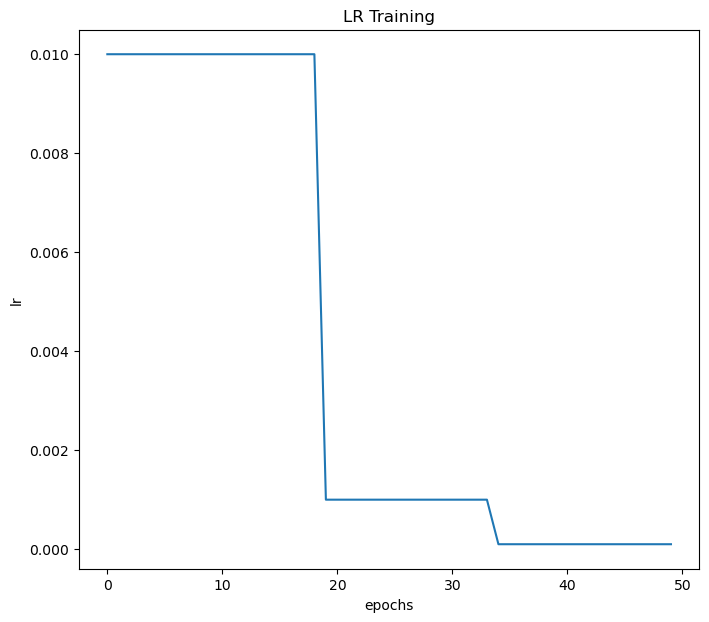

In [28]:
plt.figure(figsize = (8, 7))
plt.plot([train_history[e]['lr'] for e in train_history.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("LR Training")
plt.show()

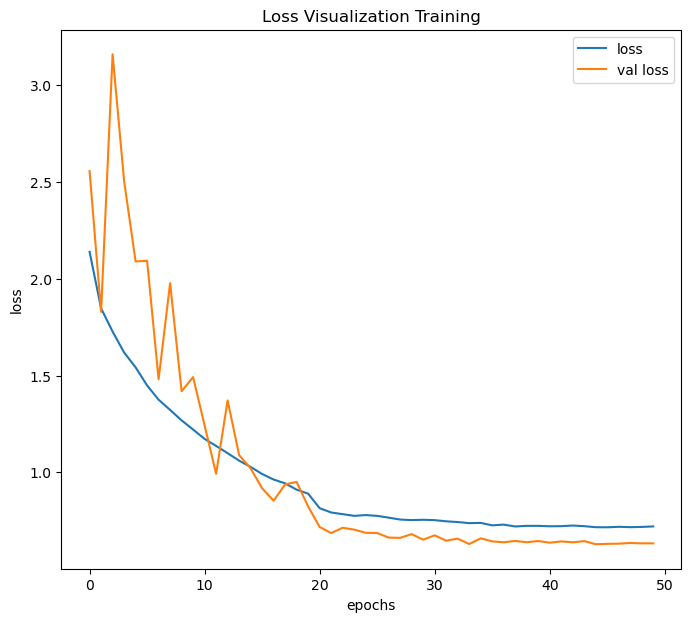

In [29]:
plt.figure(figsize = (8, 7))
plt.plot([train_history[e]['train_loss'] for e in train_history.keys()], label = 'loss')
plt.plot([train_history[e]['val_loss'] for e in train_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss Visualization Training")
plt.legend(loc = 'best')
plt.show()

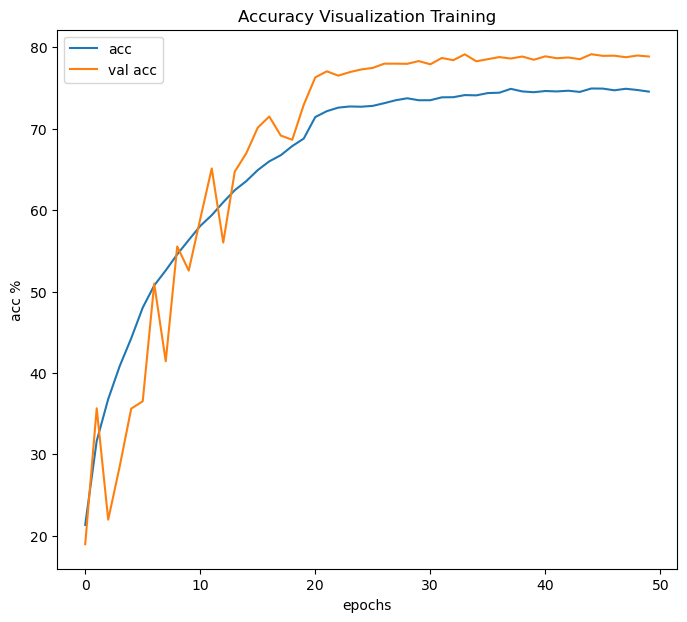

In [30]:
plt.figure(figsize = (8, 7))
plt.plot([train_history[e]['train_acc'] for e in train_history.keys()], label = 'acc')
plt.plot([train_history[e]['val_acc'] for e in train_history.keys()], label = 'val acc')
plt.xlabel("epochs")
plt.ylabel("acc %")
plt.title("Accuracy Visualization Training")
plt.legend(loc = 'best')
plt.show()

In [ ]:
# Initialize and load trained parameters-
trained_model = ResNet18().to(device = device)
trained_model.load_state_dict(torch.load("ResNet18_GeLU_best_val_acc.pth"))

val_loss, val_acc = test_one_step(
    model = trained_model, test_loader = test_loader,
    test_dataset = test_dataset
)
print(f"ResNet-18 'best' (GeLU) trained model: val loss = {val_loss:.4f} &"
      f" val acc = {val_acc:.2f}%"
     )